In [23]:
import numpy as np
import healpy as hp
import camb
import matplotlib.pyplot as plt
import astropy.io.fits as fits


In [2]:

def generate_power_spectra_CAMB(Nside,  r=10**(-2), H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, ns=0.965, lens_potential_accuracy=1, nt=0, ntrun=0, lmax_f=0, type_power='total', typeless_bool=False):
    """
    Return [Cl^TT, Cl^BB, Cl^EE, Cl^TE]
    """
    lmax_ = 3*Nside-1
    if lmax_f !=0:
        lmax_ = lmax_f
    
    pars = camb.CAMBparams(max_l_tensor=lmax_, parameterization='tensor_param_indeptilt')
    pars.WantTensors = True

    pars.Accuracy.AccurateBB = True
    pars.Accuracy.AccuratePolarization = True
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau)
    pars.InitPower.set_params(As=2e-9, ns=ns, r=r, parameterization='tensor_param_indeptilt', nt=nt, ntrun=ntrun)
    pars.max_eta_k_tensor = lmax_ + int(lmax_/15) # 100  # 15000  # 100

    # pars.set_cosmology(H0=H0)
    pars.set_for_lmax(lmax_, lens_potential_accuracy=lens_potential_accuracy)

    print("Calculating spectra from CAMB !")
    results = camb.get_results(pars)

    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True, lmax=lmax_)    
    if typeless_bool:
        return powers
    return powers[type_power]


In [3]:
def generate_HP_Map_0(Nside, CL_total, l_min=0, lmax=1536, pixwin=True, fwhm=0):
    CL_list = [CL_total[l_min:lmax,0], CL_total[l_min:lmax,3], CL_total[l_min:lmax,1], CL_total[l_min:lmax,2]]
    return hp.sphtfunc.synfast(CL_list, Nside, lmax=lmax, pixwin=pixwin, fwhm=fwhm)


In [24]:
nside = 512 #64
npix = 12*nside**2
lmax = 2*nside #120

In [6]:
c_l_total = generate_power_spectra_CAMB(nside, lmax_f=lmax)

Calculating spectra from CAMB !


In [7]:
c_l_total.shape

(1025, 4)

/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. 

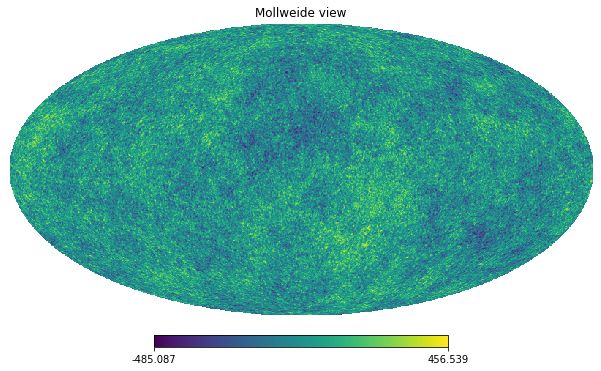

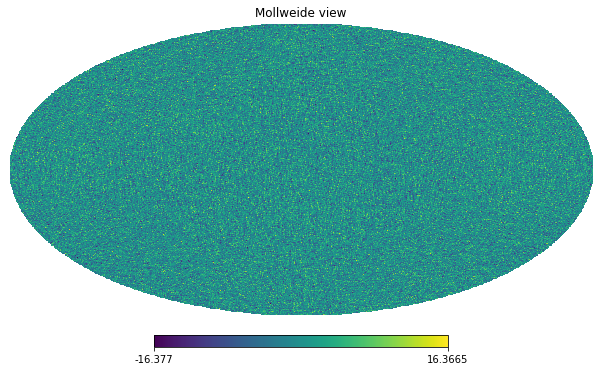

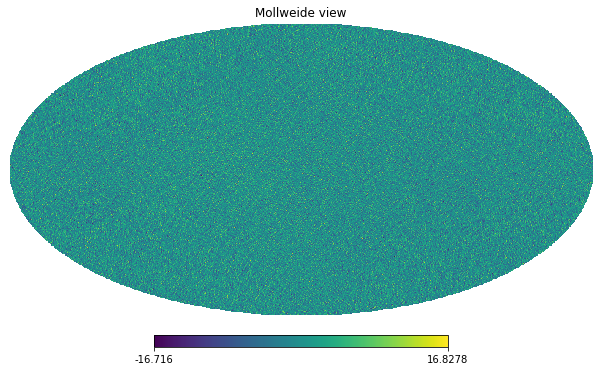

In [7]:
Map_HP = generate_HP_Map_0(nside, c_l_total, pixwin=False, lmax=lmax)#, fwhm=50*np.pi/180)

hp.mollview(Map_HP[0])
hp.mollview(Map_HP[1])
hp.mollview(Map_HP[2])

In [8]:
def save_map_Xpure_from_maps(maps_TQU, directory_path='', outname=''):
    """ maps_TQU must have the dimension (3, 12*nside**2)
    """

    print('Shape maps TQU', maps_TQU.shape)
    print('Recording 3-maps in', directory_path, outname)
    map_names = ['T', 'Q', 'U']
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH TO SAVE !!!')
        return
    list_hdu = [fits.PrimaryHDU(maps_TQU)]
    list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=map_names[i], array=maps_TQU[i,:], format='1D') for i in range(3)]))

    hdu_list = fits.HDUList(list_hdu)
    Header = fits.Header()
    # Header['ORDERING'] = 'RING'
    # Header['SIMPLE'] = 'T'
    # Header['BITPIX'] = -64
    # Header['NAXIS'] = 2
    # Header['NAXIS1']  = 204
    # Header['EXTEND']  = 'T'
    # Header['NAXIS2'] = 204
    # fits.writeto(directory_path+'bin_5_1024.fits', ell_NaMs[ell_NaMs<lmax], header=Header)
    # hdu_list.writeto(directory_path+'map_TQU_35f_4.fits')
    # hdu_list.writeto(directory_path+outname+'.fits', header=Header)
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)


In [25]:
directory_path = '/global/cscratch1/sd/mag/xPure_data/Files_Launch/'
outname = 'Map_band_limited_1024_0'


In [ ]:

save_map_Xpure_from_maps(Map_HP, directory_path=directory_path, outname=outname)
hp.write_map(directory_path+outname+'HP.fits', [Map_HP[0], Map_HP[1], Map_HP[2]])


In [26]:
Map_HP_init = hp.read_map(directory_path+outname+'HP.fits', field=(0,1,2))


In [27]:
Map_HP_init.shape

(3, 3145728)

In [10]:
lmax_plot = c_l_total.shape[0]-1

# plt.figure()
# plt.plot(np.arange(lmax_plot), hp.anafast(Map_HP_init, lmax=lmax-1).T[:,:4])
# plt.loglog()
# plt.legend(['TT', 'EE', 'BB', 'TE'])
# plt.show()

NameError: name 'c_l_total' is not defined

In [34]:
alms = hp.map2alm(Map_HP_init, lmax=lmax, use_weights=False, iter=3)

Map_HP_transformed = hp.alm2map(alms, nside, lmax=lmax, pixwin=False, fwhm=0.0, inplace=False)

In [35]:
path_map_WF = "/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_{}_{}.fits"

# Map_HP_init = np.zeros((3,npix))
Map_HP_transformed_S2HAT = np.zeros((3,npix))

for i in range(3):
    Map_HP_transformed_S2HAT[i] = hp.read_map(path_map_WF.format('BL1024', i))
    # Map_HP_init[i] = hp.read_map(path_map_WF.format('init', i))

In [36]:
for i in range(3):
    difference_HP = np.abs((Map_HP_init[i]-Map_HP_transformed[i])/Map_HP_init[i])
    difference_S2HAT = np.abs((Map_HP_init[i]-Map_HP_transformed_S2HAT[i])/Map_HP_init[i])
    print("HP : Avg {} :".format("IQU"[i]),  np.mean(difference_HP))
    print("HP : Std {} :".format("IQU"[i]),  np.std(difference_HP))
    print("HP : Max {} :".format("IQU"[i]),  np.max(difference_HP))
    print("S2HAT : Avg {} :".format("IQU"[i]),  np.mean(difference_S2HAT))
    print("S2HAT : Std {} :".format("IQU"[i]),  np.std(difference_S2HAT))
    print("S2HAT : Max {} :".format("IQU"[i]),  np.max(difference_S2HAT))
    print("")
    

HP : Avg I : 1.3027180865676932e-07
HP : Std I : 1.5506862660831576e-05
HP : Max I : 0.01616400847695524
S2HAT : Avg I : 6.83157928942016e-05
S2HAT : Std I : 0.012026351128545363
S2HAT : Max I : 17.881338123193224

HP : Avg Q : 2.1676219086740575e-07
HP : Std Q : 2.7157040033934024e-05
HP : Max Q : 0.03713793552589893
S2HAT : Avg Q : 0.0001701780827198839
S2HAT : Std Q : 0.018206328901943254
S2HAT : Max Q : 15.59313341457913

HP : Avg U : 2.683535186704451e-07
HP : Std U : 4.224129272575208e-05
HP : Max U : 0.06542982865125885
S2HAT : Avg U : 0.00016490816145478567
S2HAT : Std U : 0.04383029694695222
S2HAT : Max U : 73.26460944808913



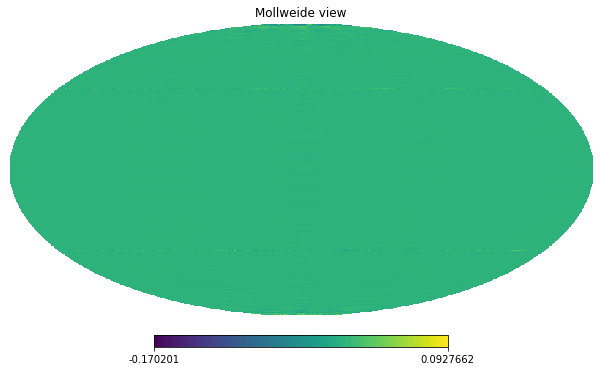

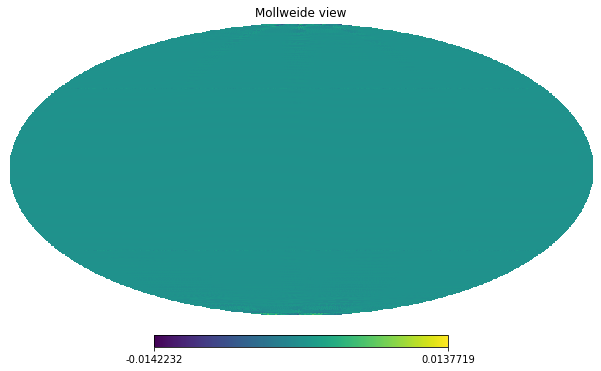

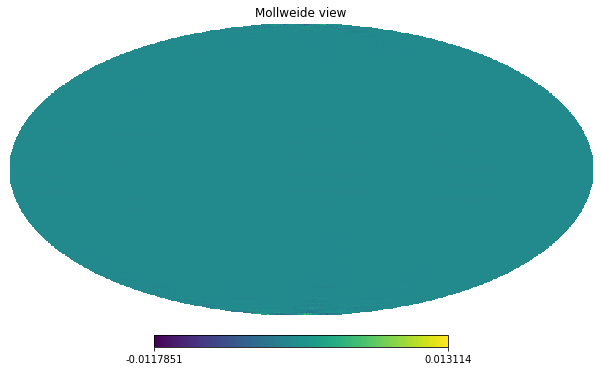

In [31]:
hp.mollview(Map_HP_init[0] - Map_HP_transformed[0])
hp.mollview(Map_HP_init[1] - Map_HP_transformed[1])
hp.mollview(Map_HP_init[2] - Map_HP_transformed[2])

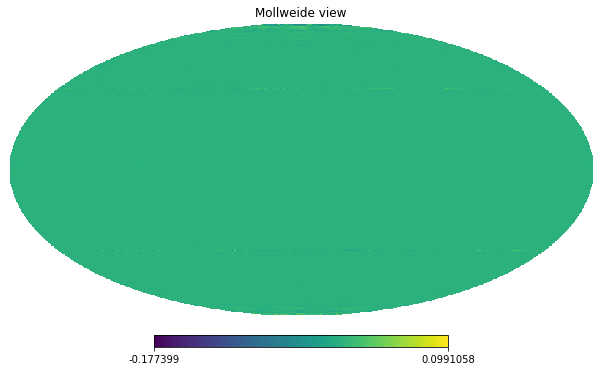

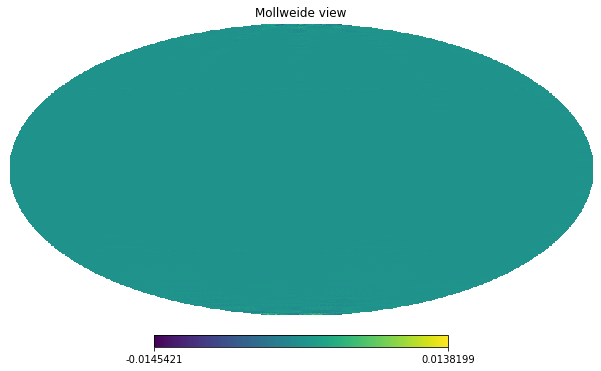

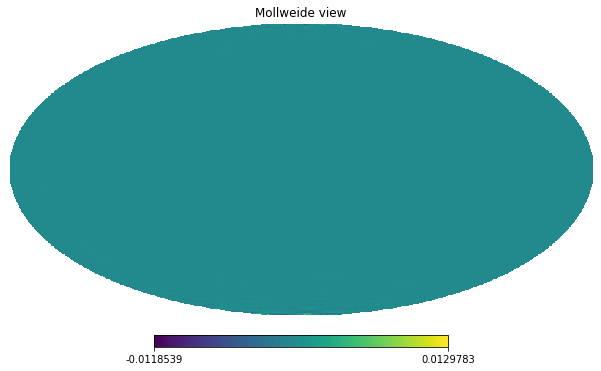

In [32]:
hp.mollview(Map_HP_init[0] - Map_HP_transformed_S2HAT[0])
hp.mollview(Map_HP_init[1] - Map_HP_transformed_S2HAT[1])
hp.mollview(Map_HP_init[2] - Map_HP_transformed_S2HAT[2])

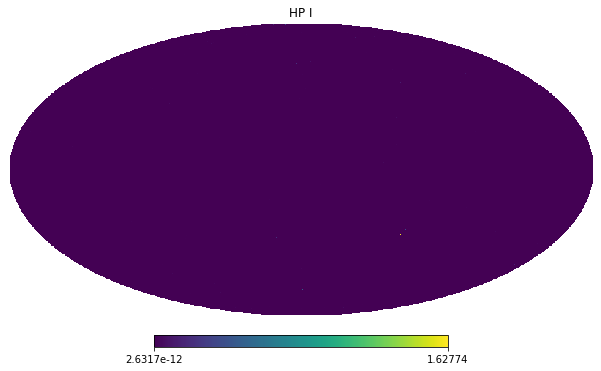

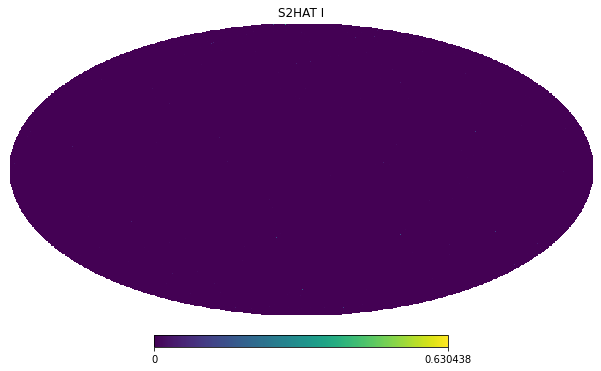

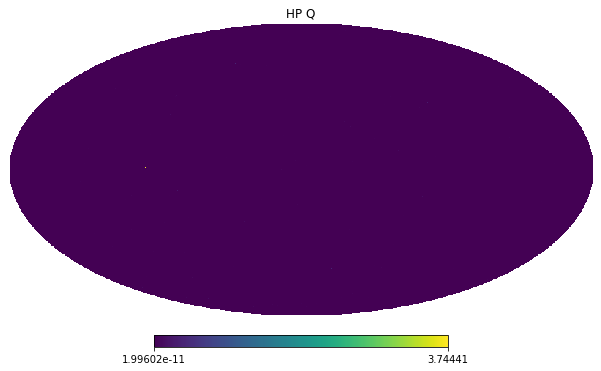

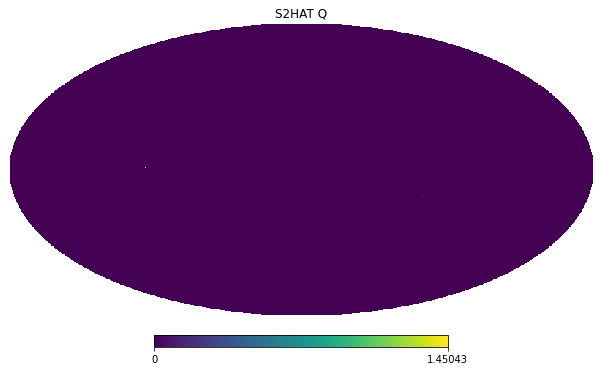

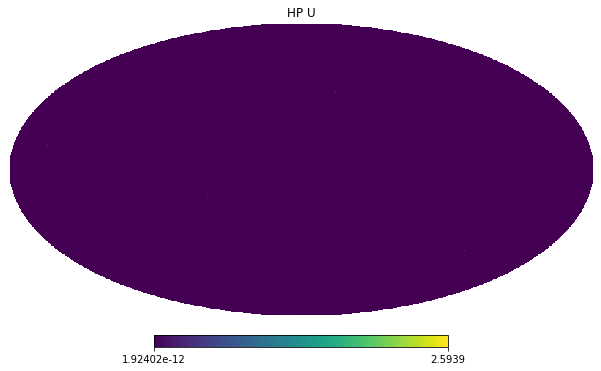

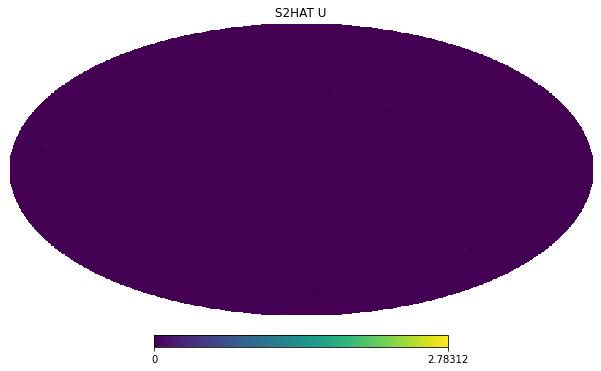

In [33]:
for i in range(3):
    hp.mollview(np.abs((Map_HP_init[i]-Map_HP_transformed[i])/Map_HP_init[i]), title='HP {}'.format("IQU"[i]))
    hp.mollview(np.abs((Map_HP_init[i]-Map_HP_transformed_S2HAT[i])/Map_HP_init[i]), title='S2HAT {}'.format("IQU"[i]))
    print("")